Draw the Oerlemans ice sheet

Troels Mikkelsen, April 2016

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# IPython
#from IPython.display import display # Used to display widgets in the notebook
from IPython.core.pylabtools import figsize

import seaborn as sns
#http://blog.xkcd.com/2010/05/03/color-survey-results/
import seaborn.xkcd_rgb as xkcd
#from bokeh.plotting import figure, show, output_notebook
#output_notebook()
import matplotlib as mpl
import matplotlib.cm as cm

figpath = 'pdf/'


# Matplotlib parameters
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.unicode']=True
fs = 26 # Font size

sns.set_style('white')
sns.set_style('ticks')
from scipy.sparse.linalg import eigs
from ipywidgets import interact, FloatSlider

# https://stackoverflow.com/questions/17958485/matplotlib-not-using-latex-font-while-text-usetex-true
from matplotlib import rc as mplrc
mplrc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mplrc('text', usetex=True)

In [12]:
import os
from ipywidgets import Button
from IPython.display import display


def savebutton(fig, figpath, figname, **kwargs):
    """ Implement a 'save figure' button.
        All kwargs are passed on to matplotlib.pyplot.savefig
    """
    if os.path.isfile(figpath + figname):
        button = Button(description='Overwrite existing figure?')
    else:
        button = Button(description='Save figure.')

    display(button)

    # The save button
    def clicketh(b):
        # http://stackoverflow.com/questions/24791709/save-a-plot-resulting-from-a-function-matplotlib-python
        fig.savefig(figpath + figname, bbox_inches='tight', **kwargs)

    button.on_click(clicketh)

In [13]:
def divide_xticklabels(ax, N=1000):
    """ Get x ticks. Divide by N. Set new labels.
    """
    ticks = ax.get_xticks()
    
    # integer ticks?
    if np.all(ticks%1 == 0):
        labels = [str('$%i$' %t) for t in ticks/N] 
    else:
        pass # Implement this
    ax.set_xticklabels(labels)

In [14]:
# R = radius of the ice sheet, in meters
R = 500*1e3
# r = horizontal coordinate; ground and ice
rground = np.linspace(-2*R, 2*R, 1000)
rice = np.linspace(-R, R, 1000)
# rc = where the ocean begins; dim(rc) = [m]
rc = 800*1e3
# d0 = undisturbed bed height at center, in meters
d0 = 1545
# s = slope of bedrock
s = d0 / rc
# mu0 = "profile parameter" [m^(1/2)]
mu0 = 8
# mu and c take into account that the mean surface elevation wil
# decrease for increasing s; dim(s) = [m^(1/2)]
c = 2e6
# Equilibrium line at T = 0 [m]
hE0 = 1545

def mufunc(c, s):
    """ Oerlemans, Equation 4
    """
    return mu0 + c*s**2
mu = mufunc(c, s)

# Undisturbed bed height - linear slope
def d(r):
    """ Oerlemans, Equation 2
    """
    return d0 - s*np.abs(r)

# Surface elevation of the ice sheet
def h(r, R):
    """ Oerlemans, Equation 3
    """
    rabs = np.abs(r)
    return d0 - s*R + np.sqrt(mu*(R - rabs))

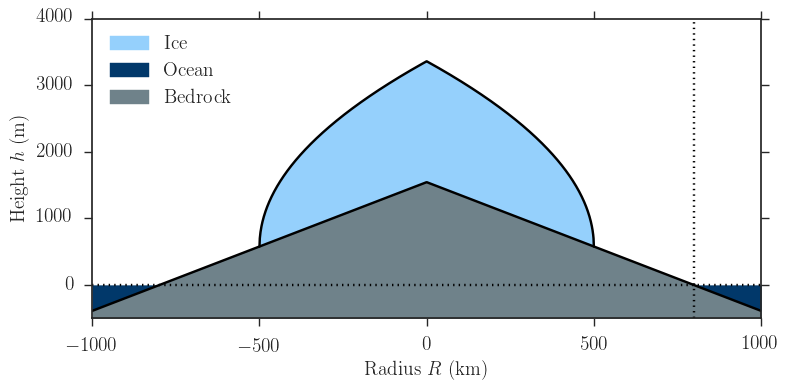

In [15]:
fs = 14 # Font size
figsize(8, 4)
fig, ax = plt.subplots(1, 1)

# Plot Grounding line
ax.plot(rground, d(rground), c='k')

# Plot ice
ax.plot(rice, h(rice, R), c='k')

# Radius of continent and sea level
ax.axvline(rc, c='k', linestyle=':')
ax.axhline(0, c='k', linestyle=':')

# Fill areas - ice
ax.fill_between(rice, d(rice), h(rice, R), color=xkcd['light blue'], label='Ice')
# Water
ax.fill_between(rground, d(rground), 0, color=xkcd['marine blue'], label='Ocean')
# Ground
ax.fill_between(rground, ax.get_ylim()[0], d(rground), color=xkcd['steel grey'], label='Bedrock')

ax.legend(loc='upper left', fontsize=fs)

# Pretty
divide_xticklabels(ax, 1000)
ax.set_xlabel('Radius $R$ (km)', fontsize=fs)
ax.set_ylabel(r'Height $h$ (m)', fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
plt.locator_params(nbins=5)
ax.set_ylim(-500, 4000)

# Save
# https://stackoverflow.com/questions/12490657/how-can-i-save-this-matplotlib-figure-such-that-the-x-axis-labels-are-not-croppe
fig.tight_layout()
savebutton(fig, figpath, 'OerlemansModel.pdf')

In [16]:
# Plot the mass balance - define functions
A0      = 1.0
beta = 0.005
CR      = 5e5
hE0 = 1545
Tbar = 5.8

# 'Adjustable' parameters
Rstart = 5e5 # Starting value in simulation

def Afunc_desert(R):
    """ Desert effect. See Oerlemans (2003) Eq. 20.
    """
    return A0*np.exp(-R/CR);

def Afunc_none(R):
    return A0

def hEq_f(T, he0):
    """ Return height of equilibrium line. Oerlemans (2008).
    """
    return he0 + (T - Tbar)*1000/6.5;

def hR_f(hE, A, beta):
    """ Runoff-line. Oerlemans (2003), Eq. 15
    """
    return hE + A/beta

In [17]:
#A = Afunc(Rstart)

def B_f(h, R, T, he0, a_function):
    """ Oerlemans (2003) Eqs. 14a + 14b
    """
    
    # The 'A' parameter
    A = a_function(R)
    
    # Height of equilibrium line
    he = hEq_f(T, he0)
    
    # Height of runoff line
    hr = hR_f(he, A, beta)
    
    if h >= hr:
        return A
    
    if h < hr:
        return A - beta*(hr - h)

In [18]:
ruse = Rstart
tuse = 0

B_f(2000, ruse, tuse, hE0, Afunc_desert)

0.36787944117144233

In [19]:
#z = np.linspace(0, 3000, 1000)
vectorB = np.vectorize(B_f)
#b = vectorB(z, ruse, tuse, hE0)

In [20]:
# plot...

In [24]:
fs = 26 # Font size
def plot_specific_balance(T, R, he0, a_function, ret_figax=False):
    z = np.linspace(0, 3000, 1000)
    b = vectorB(z, R, T, he0, a_function)
    eq = hEq_f(T, he0)
    ro = hR_f(eq, a_function(R), beta)

    # Plot
    fig, ax = plt.subplots(1, 1)
    
    # Plot specific balance
    ax.plot(b, z, c=xkcd['cerulean'], label=r'$B$')

    # Plot eq-line
    ax.axhline(eq, c=xkcd['scarlet'], lw=1.5, label=r'$h_{Eq}$')
    ax.axhline(ro, c='k', lw=0.75, label=r'$h_r$')

    ax.legend(loc='upper left')
    
    # Vertical line at zero
    ax.axvline(0, lw=0.75, c='k', linestyle=':')
    ax.set_ylabel(r'Altitude $h$ [m]')
    ax.set_xlabel(r'Specific balance $B$ [m ice/yr]')
    
    ax.set_ylim(0, 3000)
    ax.set_xlim(-8, 2)
    
    if ret_figax:
        return fig, ax

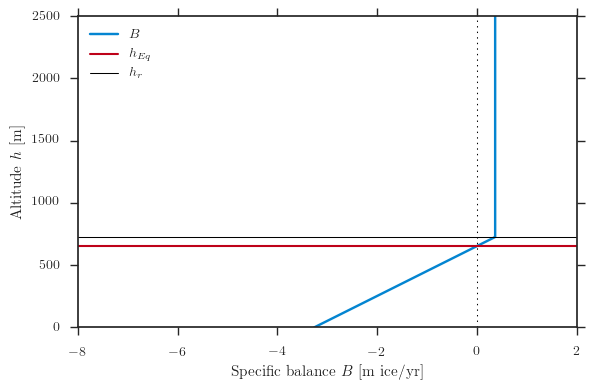

In [27]:
figsize(6, 4)
fig, ax = plot_specific_balance(0, Rstart, hE0, Afunc_desert, ret_figax=True)
ax.set_ylim(0, 2500)
ax.set_xlim(-8, 2)
plt.tight_layout()
savebutton(fig, figpath, 'OerlemansMassBalance.pdf', dpi=600)

In [ ]:
figsize(8, 6)
interact(plot_specific_balance, 
         T=FloatSlider(value=0, min=-5.0, max=5.0, step=0.1, description=r'$T$'), 
         R=FloatSlider(value=5e5, min=1e5, max=1e6, step=1e2, description=r'$R$'), 
         he0=FloatSlider(value=1545, min=0, max=2000, step=10, description=r'$h_{E, 0}$'),
         a_function={'Desert effect':Afunc_desert, 'No desert':Afunc_none}
        )